In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
import timeit
import pyext.src.matrix as mat
import pyext.src.stats as stats

from src.wishart_synthetic_benchmark import (
    ccscatter,
    check_cov,
    df_from_stats,
    get_precision_matrix_stats,
    get_prior_pred,
    helper_vline_hist,
    margins_plot,
    quad_plot,
    randPOSDEFMAT,
    rprior,
    rprior_pred,
    sample_from_prior,
    scatter_plot,
    simulate_from_prior,
    try_sampling,
    ground_truth_pair_plot
)

from src.cullin_benchmark_test import (
    CullinBenchMark,
    accumulate_indicies,
    bar_plot_df_summary,
    binary_search,
    biogrid_df_report,
    check_biogrid_data,
    check_bounds,
    compare_reports,
    find_bounds,
    find_end,
    find_start,
    format_biogrid_df_report,
    get_all_indicies,
    get_biogrid_summary,
    get_json_report_from_report,
    make_bounds,
    show_idmapping_results,
    transform_and_validate_biogrid,
    uniprot_id_mapping,
)

def get_experimental_coverage_df(biogrid_df, report):
    
    df = biogrid_df
    nodes = report['unique_GeneId_set']
    nodes = sorted(nodes)
    d =pd.DataFrame(data = np.zeros((len(nodes), len(nodes))), index = nodes, columns = nodes, dtype=float)
    
    experiments = {key: i for i, key in enumerate(set(df["Experimental System"]))}
    
    j = 0
    for i, row in biogrid_df.iterrows():
        nodeA = row.iloc[1]
        nodeB = row.iloc[2]
        
        if nodeB > nodeA:
            t = nodeA
            nodeA = nodeB
            nodeB = t
        
        experiment = row["Experimental System"]
        val = experiments[experiment]
        
        d.loc[nodeA, nodeB] += val
        j +=1

    return d

def triangular_to_symmetric(A):
    Lower = np.tril(A)
    diag_indices = np.diag_indices(len(A))
    Lower = Lower + Lower.T
    Lower[diag_indices] = A[diag_indices]
    return Lower

def coverage_plot(d, w=12, h=12, title="Experimental Coverage of Cullin BG"):

    
    
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    
    ax = axs[0]
    mappable = ax.imshow(triangular_to_symmetric(d.values != 0))
    ax.set_title(title)
    #plt.colorbar(mappable, ax=ax)
    ax = axs[1]
    ax.imshow(d.values)
    ax.set_title("Null")
    plt.tight_layout()
    plt.show()
    
def transform_cullin_benchmark_data(df, id_mapping):
    out = np.zeros((len(df), 4))
    out_ctrl = np.zeros((len(df), 12))
    entrez = []
    j=0
    for i, row in df.iterrows():
        out[j, :] = split(row["Spec"])
        out_ctrl[j, :] = split(row["ctrlCounts"])
        entrez.append(to_entrez(row["Prey"], id_mapping))
        j+=1
    
    
    for i in range(1, 5):
        #assert f"r{i}" not in df.columns
        df[f"r{i}"] = out[:, i-1]
        
    for i in range(1, 13):
        #assert f"ctrl_{i}" not in df.columns
        df[f"ctrl_{i}"] = out_ctrl[:, i-1]
        
    assert "Entrez" not in df.columns
    df["Entrez"] = entrez
    
    return df

def split(u):
    a = u.split("|")
    for i in a:
        assert i.isdigit()
    a = [int(i) for i in a]
    for i in a:
        assert 0 <= i < 256
    a = np.array(a)
    return a

def to_entrez(u, id_mapping):
    return id_mapping[u] if u in id_mapping else "-"

def get_bounds_from_id_mapping(id_mapping, biogrid):
    eids = set(val for key, val in id_mapping.items())

    colA = "Entrez Gene Interactor A"
    colB = "Entrez Gene Interactor B"

    col = colA
    eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
    eids_in_biogrid.remove(None)
    bounds_A = make_bounds(biogrid, col, eids_in_biogrid)

    col = colB
    eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
    eids_in_biogrid.remove(None)
    bounds_B = make_bounds(biogrid, col, eids_in_biogrid)


    check_bounds(biogrid, bounds_A, eids, colnum=1)
    check_bounds(biogrid, bounds_B, eids, colnum=2)
    return bounds_A, bounds_B, eids_in_biogrid

In [2]:
# Flags

GET_CULLIN_BG = True

In [3]:
# Global helper functions

inv = sp.linalg.inv

In [4]:
# Global Plotting params

divergent = "seismic"
sequential = "Reds"

In [5]:
%%bash
shasum -c ../data/biogrid/checksum512.txt

../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt: OK


In [6]:
check_biogrid_data()

Checking biogrid data for missing tabs
Passed
n-lines 2312699


In [7]:
%%bash
shasum -c ../data/biogrid/checksum512.txt

../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt: OK


In [8]:
biogrid = pd.read_csv("../data/biogrid/BIOGRID-ALL-4.4.206.tab3.txt", delimiter="\t")

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
biogrid = transform_and_validate_biogrid(biogrid)

Processing Entrez Gene Interactor A
Processing Entrez Gene Interactor B
Change dtypes to categorical
Select columns


In [10]:
# Load in the Cullin Data
cullin_benchmark = CullinBenchMark(dirpath=Path("../data/cullin_e3_ligase"))
#cullin_benchmark.load_data()

In [11]:
# Do Uniprot ID mapping
id_mapping, failed_ids, prey_set_idmapping_input = uniprot_id_mapping(cullin_benchmark)

from UniProtKB_AC-ID to GeneID size 5000
POST https://rest.uniprot.org/idmapping/run
          respone  200
          jobId 247fb1d8d8a9b8a14d4efd402f9faa3c1c598468
Waiting 15 s
GET https://rest.uniprot.org/idmapping/status/247fb1d8d8a9b8a14d4efd402f9faa3c1c598468
GET https://rest.uniprot.org/idmapping/stream/247fb1d8d8a9b8a14d4efd402f9faa3c1c598468


In [12]:
show_idmapping_results(id_mapping, failed_ids, prey_set_idmapping_input)

13 failed to map
2834 succeeded
of 2847 total


In [13]:
# Check the Failed Cases
failed_df = cullin_benchmark.data[cullin_benchmark.data['Prey'].apply(lambda x: x in failed_ids)]

# The failed cases amount to only 20 Bait prey Pairs
# The Saint Score < 0.14 for all cases
# Therefore we ignore the 13 failed cases instead of mapping them
# Except for L0R6Q1. Consider for later

In [14]:
# Set the Values for the Entrez Gene Id Columns

eids = set(val for key, val in id_mapping.items())

colA = "Entrez Gene Interactor A"
colB = "Entrez Gene Interactor B"

col = colA
eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
eids_in_biogrid.remove(None)
bounds_A = make_bounds(biogrid, col, eids_in_biogrid)

col = colB
eids_in_biogrid = set(map(lambda x: x if int(x) in biogrid.loc[:, col] else None, eids))
eids_in_biogrid.remove(None)
bounds_B = make_bounds(biogrid, col, eids_in_biogrid)
            

check_bounds(biogrid, bounds_A, eids, colnum=1)
check_bounds(biogrid, bounds_B, eids, colnum=2)

In [15]:
if GET_CULLIN_BG:
    index_labels = get_all_indicies(biogrid, bounds_A, bounds_B, 1, 2)

    # Look at the subset of biogrid

    cullin_bg = biogrid.loc[index_labels]

    # Validate the data frame
    assert np.all(cullin_bg.iloc[:, 1].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))
    assert np.all(cullin_bg.iloc[:, 2].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))

    nnodes = len(eids_in_biogrid)
    n_possible_edges = int(0.5*nnodes*(nnodes-1))

    nself = len(cullin_bg[cullin_bg.iloc[:, 1]==cullin_bg.iloc[:, 2]])
    not_self = cullin_bg.iloc[:, 1]!=cullin_bg.iloc[:, 2]

    cullin_bg = cullin_bg[not_self]

    #df = cullin_bg


    # How many edges are unique?

2751 incoming bounds
2822 incoming bounds


In [16]:
cullin_report = biogrid_df_report(cullin_bg)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [18]:
# Annotate the cullin benchmark with entrez genes and rows and columns
cullin_benchmark_transformed = transform_cullin_benchmark_data(cullin_benchmark.data, id_mapping)

In [19]:
# Define the training set
bait_name = "CBFBwt_MG132"
s = cullin_benchmark_transformed["Bait"] == bait_name
trainingset = cullin_benchmark_transformed[s]

saint_cutoff = 0.7
s = trainingset["SaintScore"] >= saint_cutoff

trainingset = trainingset[s]

In [20]:
# Get the biogrid subset for the training set
training_set_id_mapping = {key:id_mapping[key] for key in trainingset.iloc[1:len(trainingset), 1]} # ignore vifprotein
s = False
training_set_eid_set= set(trainingset["Entrez"])
for key, entrezid in training_set_id_mapping.items():
    s1 = cullin_bg["Entrez Gene Interactor A"] == float(entrezid)
    s = s1 | s

# Select the union
for key, entrezid in training_set_id_mapping.items():
    s1 = cullin_bg["Entrez Gene Interactor B"] == float(entrezid)
    #s = s1 & s

    

# Superset of at least one interactor



assert len(s) == len(cullin_bg)

training_bg = cullin_bg[s]

In [21]:
training_bg[training_bg[colA] == 9616.0]

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,Experimental System,Experimental System Type,Score,Organism Name Interactor A,Organism Name Interactor B
574,23024,9616.0,8065.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
675,26025,9616.0,8454.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
711,26870,9616.0,8451.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
712,26871,9616.0,8453.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
2115684,3027041,9616.0,51130.0,Affinity Capture-MS,physical,0.999997,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...
1019105,1521811,9616.0,6923.0,Reconstituted Complex,physical,NaN,Homo sapiens,Homo sapiens
1019106,1521812,9616.0,6921.0,Reconstituted Complex,physical,NaN,Homo sapiens,Homo sapiens
1019108,1521814,9616.0,8065.0,Biochemical Activity,physical,NaN,Homo sapiens,Homo sapiens
496648,728385,9616.0,7428.0,Affinity Capture-Western,physical,NaN,Homo sapiens,Homo sapiens


In [22]:
# Generate the report for the training data
trainingset_report = biogrid_df_report(cullin_bg)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [23]:
# Experimental Coverage
trainingset_bg_coverage = get_experimental_coverage_df(training_bg, trainingset_report)

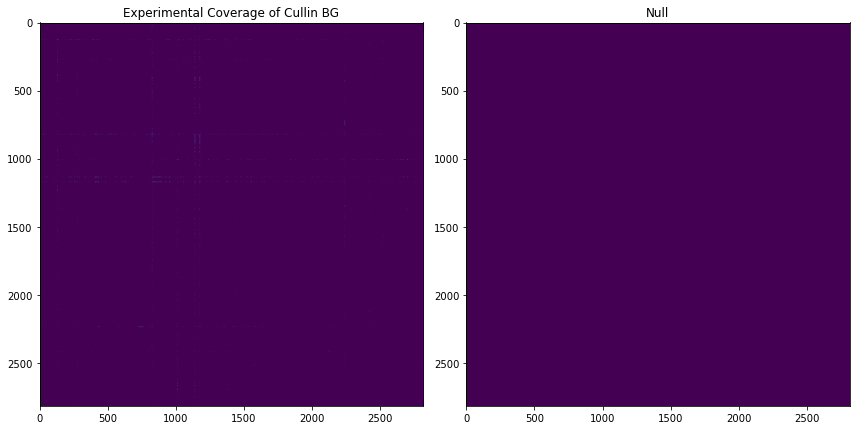

In [24]:
coverage_plot(trainingset_bg_coverage)

In [25]:
training_bg

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,Experimental System,Experimental System Type,Score,Organism Name Interactor A,Organism Name Interactor B
42,3331,6117.0,4171.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
574,23024,9616.0,8065.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
675,26025,9616.0,8454.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
711,26870,9616.0,8451.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
712,26871,9616.0,8453.0,Two-hybrid,physical,NaN,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...
504198,740826,6117.0,6119.0,Co-fractionation,physical,0.948,Homo sapiens,Homo sapiens
509735,746363,10015.0,9525.0,Co-fractionation,physical,0.808,Homo sapiens,Homo sapiens
510431,747059,6117.0,51035.0,Co-fractionation,physical,0.951,Homo sapiens,Homo sapiens
515513,752142,2010.0,55234.0,Co-fractionation,physical,0.785,Homo sapiens,Homo sapiens


In [29]:
# highlight the area of interaction using labels
# remove the '-'
try:
    training_set_eid_set.remove("-")
except KeyError:
    ...
training_set_eid_list = [float(i) for i in training_set_eid_set]
trainingset_bg_coverage = trainingset_bg_coverage.loc[training_set_eid_list, training_set_eid_list]



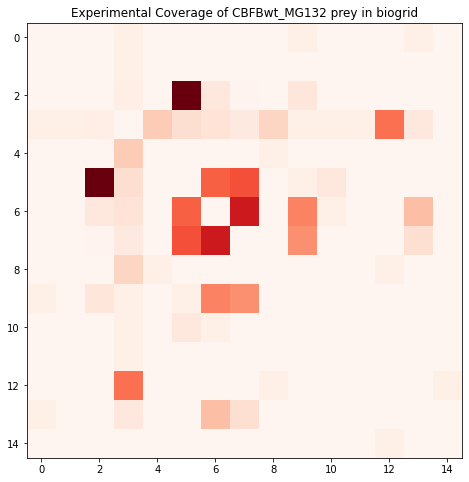

In [30]:
w = 8
h = 8

plt.figure(figsize=(w, h))
plt.title(f"Experimental Coverage of {bait_name} prey in biogrid")
plt.imshow(trainingset_bg_coverage + trainingset_bg_coverage.T, vmin=0, cmap=sequential)
#xlabels = 
plt.show()

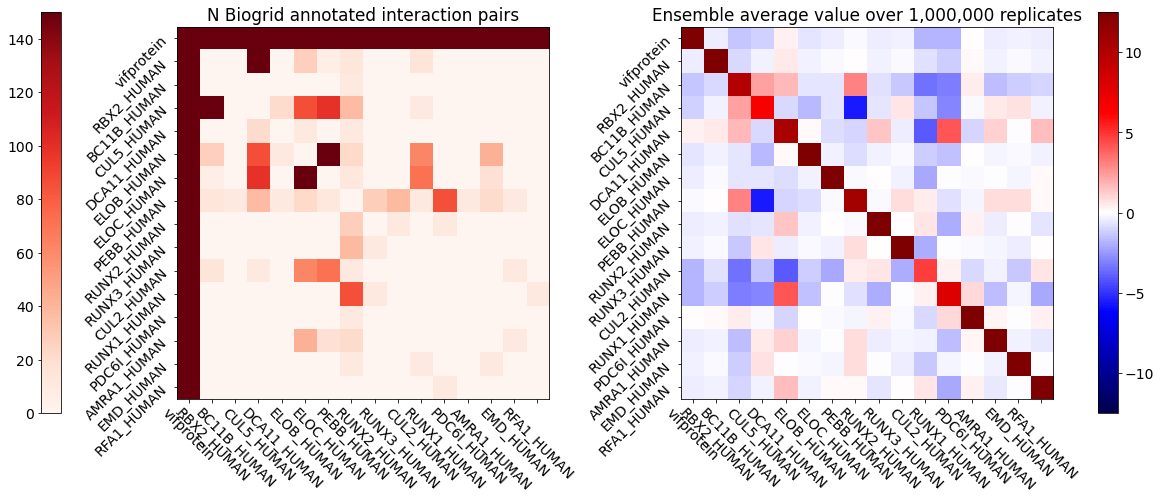

In [114]:
cols = list(eid_to_preygene.keys())
cols = cols[1:len(cols)] # drop '-'
cols = [float(i) for i in cols]

scratch = training_bg_coverage.loc[cols, cols]

fig1 = np.ones((p, p)) * 1000
fig1[1:p, 1:p] = scratch
fig, axs = ground_truth_pair_plot((fig1 + fig1.T) // 2, 
                                  np.array(np.mean(exp.samples, axis=0)), 
                                 overwrite_diags=False,
                                 vmin1=0, vmax1=150,
                                 vmin2=-12.5, vmax2=12.5,
                                 cmap1=sequential, cmap2=divergent)



axs[0].set_title(f"N Biogrid annotated interaction pairs")
axs[1].set_title(f"Ensemble average value over {'{:,}'.format(n_samples)} replicates")

xlabels1 = trainingset_bg_coverage.columns
eid_to_preygene = {}
for i, row in trainingset.loc[:, ["PreyGene", "Entrez"]].iterrows():
    eid_to_preygene[row["Entrez"]] = row["PreyGene"]

xlabels = [eid_to_preygene[str(int(eid))] for eid in cols]



axs[0].set_xticks(ticks=np.arange(p), labels=["vifprotein"] + xlabels, rotation=-45)
axs[0].set_yticks(ticks=list(range(p)), labels=["vifprotein"] + xlabels, rotation=45)

axs[1].set_xticks(ticks=np.arange(p), labels=list(trainingset["PreyGene"]), rotation=-45)
axs[1].set_yticks(ticks=np.arange(p), labels=list(trainingset["PreyGene"]), rotation=45)
plt.show()

In [107]:
["-"] + ["a", 1, 7]

['-', 'a', 1, 7]

Text(0.5, 0, 'Average edge value')

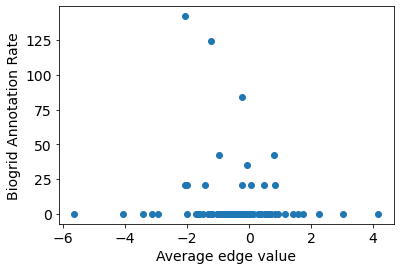

In [99]:
assert exp.samples.shape == (n_samples, 16, 16)
assert scratch.shape == (15, 15)
scratch2 = np.mean(exp.samples, axis=0)
scratch2 = scratch2[1:16, 1:16]
assert scratch2.shape == scratch.shape


plt.scatter(scratch2[np.tril_indices(15, k=-1)], scratch.values[np.tril_indices(15, k=-1)])
plt.ylabel("Biogrid Annotation Rate")
plt.xlabel("Average edge value")

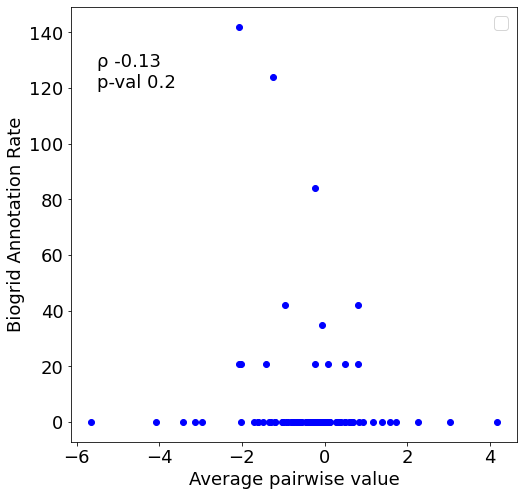

In [123]:


import matplotlib as mpl
with mpl.rc_context({"font.size": 18}):

    plt.figure(figsize=(8, 8))

    assert exp.samples.shape == (n_samples, 16, 16)
    assert scratch.shape == (15, 15)
    scratch2 = np.mean(exp.samples, axis=0)
    scratch2 = scratch2[1:16, 1:16]
    assert scratch2.shape == scratch.shape


    x = scratch2[np.tril_indices(15, k=-1)]
    y = scratch.values[np.tril_indices(15, k=-1)]
    plt.plot(x, y, "o",color="b")
    plt.ylabel("Biogrid Annotation Rate")
    plt.xlabel("Average pairwise value")
    
    r, pval = sp.stats.pearsonr(x, y)
    
    decimals = 2
    r = np.round(r, decimals)
    pval = np.round(pval, decimals)
    s = "\N{greek small letter rho}"
    s += f" {r}"
    s += f"\np-val {pval}"
    plt.text(-5.5, 120, s)
    
    #plt.xlabel("Ground Truth")

    plt.legend()
    
    plt.show()

In [124]:
# Map Prey Gene names to columns

?sp.stats.pearsonr


In [80]:
cols = list(eid_to_preygene.keys())
cols = cols[1:len(cols)] # drop '-'
cols = [float(i) for i in cols]

In [85]:
training_bg_coverage.loc[cols, cols]

,9616.0,64919.0,8065.0,80344.0,6923.0,6921.0,865.0,860.0,864.0,8453.0,861.0,10015.0,55626.0,2010.0,6117.0
9616.0,0.0,0.0,301.0,0.0,54.0,12.0,27.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0
64919.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8065.0,0.0,0.0,0.0,0.0,172.0,199.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80344.0,0.0,0.0,42.0,0.0,21.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923.0,0.0,0.0,0.0,0.0,0.0,329.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6921.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
865.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,76.0,0.0,171.0,0.0,0.0,0.0,0.0
860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8453.0,0.0,0.0,21.0,0.0,124.0,142.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0


In [69]:
eid_to_preygene

{'-': 'vifprotein',
 '9616': 'RBX2_HUMAN',
 '64919': 'BC11B_HUMAN',
 '8065': 'CUL5_HUMAN',
 '80344': 'DCA11_HUMAN',
 '6923': 'ELOB_HUMAN',
 '6921': 'ELOC_HUMAN',
 '865': 'PEBB_HUMAN',
 '860': 'RUNX2_HUMAN',
 '864': 'RUNX3_HUMAN',
 '8453': 'CUL2_HUMAN',
 '861': 'RUNX1_HUMAN',
 '10015': 'PDC6I_HUMAN',
 '55626': 'AMRA1_HUMAN',
 '2010': 'EMD_HUMAN',
 '6117': 'RFA1_HUMAN'}

In [32]:
training_bg_coverage = get_experimental_coverage_df(cullin_bg, cullin_report)

In [33]:
# Get Biogrid for the training set

index_labels = get_all_indicies(biogrid, bounds_A, bounds_B, 1, 2)

# Look at the subset of biogrid

cullin_bg = biogrid.loc[index_labels]

# Validate the data frame
assert np.all(cullin_bg.iloc[:, 1].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))
assert np.all(cullin_bg.iloc[:, 2].apply(lambda x: True if str(int(x)) in eids_in_biogrid else False))

nnodes = len(eids_in_biogrid)
n_possible_edges = int(0.5*nnodes*(nnodes-1))

nself = len(cullin_bg[cullin_bg.iloc[:, 1]==cullin_bg.iloc[:, 2]])
not_self = cullin_bg.iloc[:, 1]!=cullin_bg.iloc[:, 2]

cullin_bg = cullin_bg[not_self]

2751 incoming bounds
2822 incoming bounds


In [43]:
# Operate on
cols = ["r1", "r3", "r3", "r4"]

df = trainingset
U = df[cols] @ df[cols].T
p = len(U)


# log10 transformation(SC) + prior

# Do the sampling
V = inv(U / 4 + np.eye(p))
key = jax.random.PRNGKey(3721)
n_samples = 1000000
exp = sample_from_prior(key, 15, p, n_samples, V)

In [35]:
# How many failed ids are in the training set?

len(set(failed_ids).intersection(df["Prey"]))
# Conclusion - all ids except vif mapped

0

In [36]:
# Get the experimental coverage in biogrid

        
d = get_experimental_coverage_df(cullin_bg, cullin_report)

In [37]:
# Annotate the cullin benchmark with entrez genes and rows and columns
cullin_benchmark_transformed = transform_cullin_benchmark_data(cullin_benchmark.data, id_mapping)

AssertionError: 

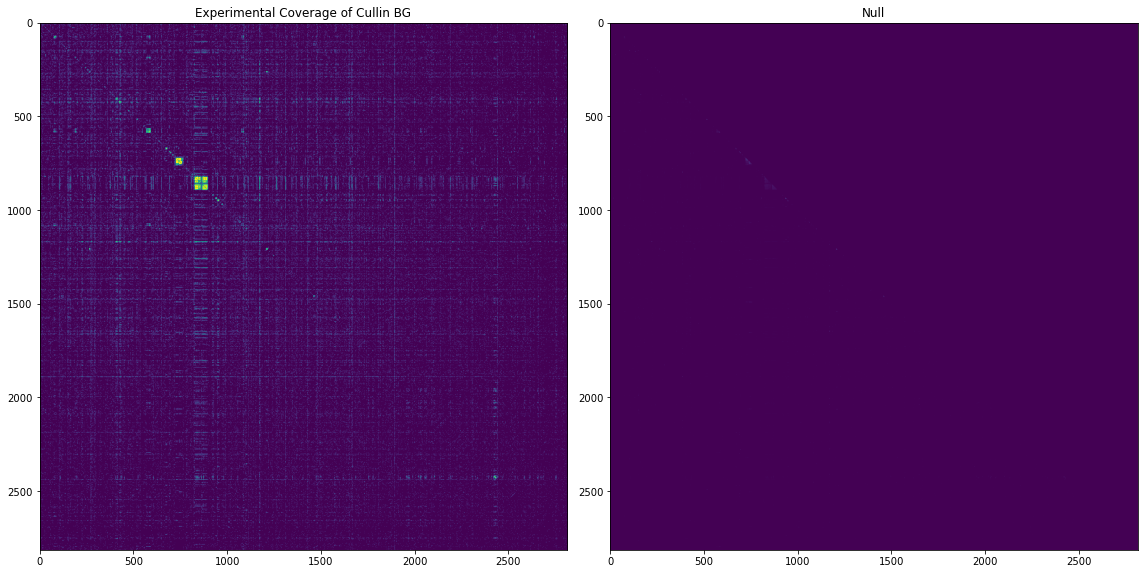

In [38]:
coverage_plot(d, w=16, h=14,)

(<Figure size 1152x1152 with 4 Axes>,
 array([<AxesSubplot:title={'center':'log 10 correlations'}>,
        <AxesSubplot:title={'center':'Precision + Prior'}>], dtype=object))

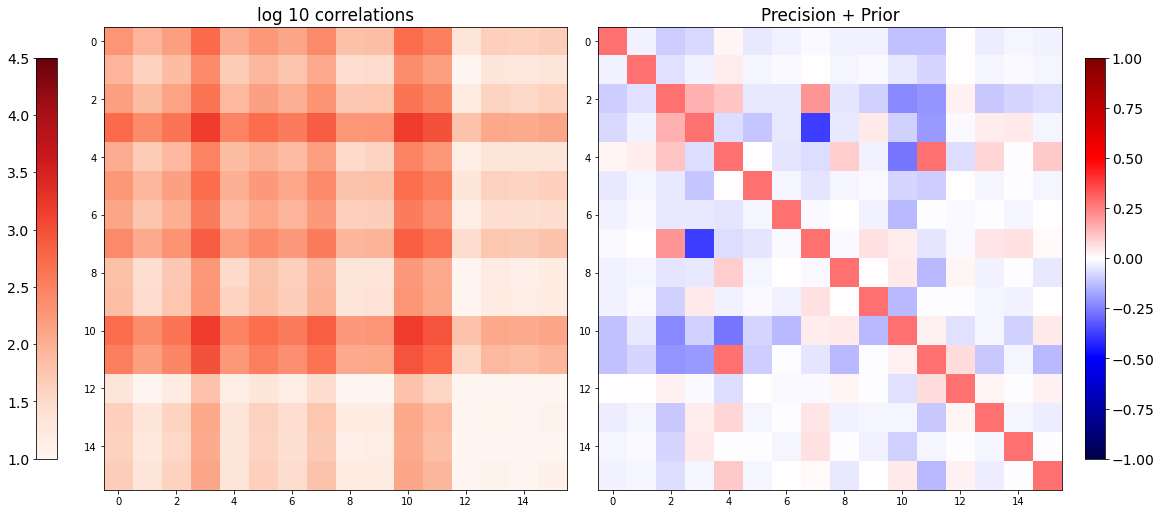

In [39]:
ground_truth_pair_plot(np.log10(U / 16), inv(U + np.eye(p)),
                      vmin1=1, vmax1=4.5, vmin2=-1., vmax2=1.,
                      cmap1=sequential, cmap2=divergent, title1="log 10 correlations", title2="Precision + Prior")


(<Figure size 1152x1152 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Precision + Prior'}>,
        <AxesSubplot:title={'center':'Scaled Precision + Prior'}>],
       dtype=object))

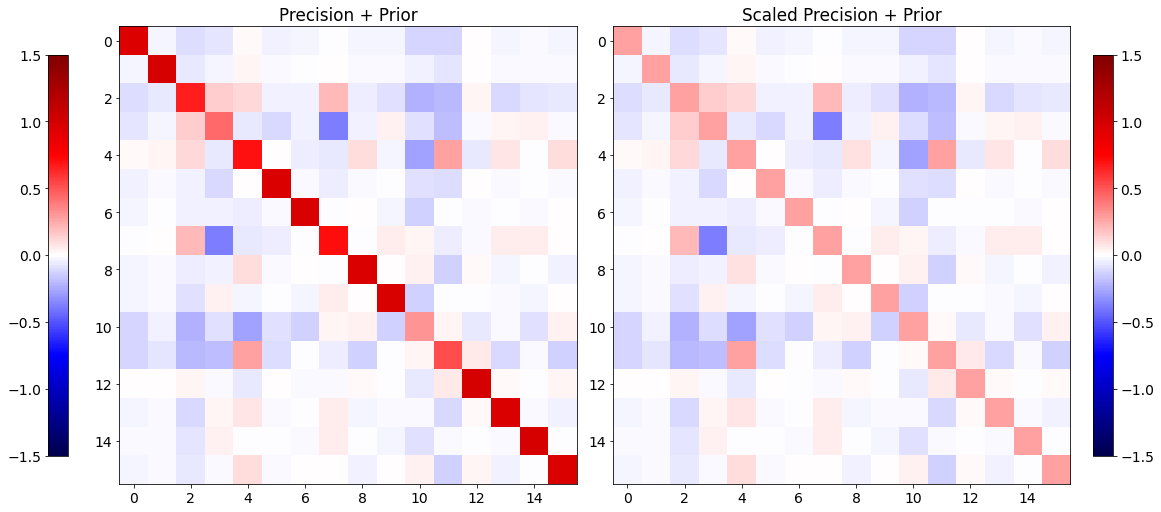

In [40]:
ground_truth_pair_plot(inv(U + np.eye(p)), inv(U/4 + np.eye(p)),
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5,
                      cmap1=divergent, cmap2=divergent, title1="Precision + Prior", title2="Scaled Precision + Prior")

In [ ]:
# 4 replicate Plot

fig, axs = ground_truth_pair_plot(np.array(np.var(exp.samples, axis=0)), np.array(np.mean(exp.samples, axis=0)), 
                                 overwrite_diags=False,
                                 vmin1=0,
                                 vmin2=-12.5, vmax2=12.5,
                                 cmap1=sequential, cmap2=divergent)

axs[0].set_title(f"Ensemble average variance")
axs[1].set_title(f"Ensemble average value over {'{:,}'.format(n_samples)} replicates")
plt.show()

In [ ]:
cocrystal_sel = cullin_bg["Experimental System"] == "Co-crystal Structure"
cullin_bg_cocrystal = cullin_bg[cocrystal_sel]

In [ ]:
s = cullin_benchmark_transformed["Bait"] == bait_name
s2 = cullin_benchmark_transformed["SaintScore"] >= saint_cutoff
s3 = s & s2
assert np.alltrue(cullin_benchmark_transformed.loc[s3,cols] == df[cols])

In [ ]:
# Check the experimental coverage for the training set
trainingset = cullin_benchmark_transformed[s3]
trainingset_report = biogrid_df_report(cullin_bg)

In [ ]:
# Must select a subset of biogrid, then do the report

In [ ]:
trainingset_coverage = get_experimental_coverage_df(trainingset, cullin_benchmark_transformed)

coverage_plot(trainingset_coverage)

In [ ]:
?coverage_plot

In [ ]:
?biogrid_df_report

In [ ]:
bait_name

In [ ]:
s = cullin_benchmark_transformed["Bait"] == bait_name
s2 = cullin_benchmark_transformed["SaintScore"] >= saint_cutoff
s3 = s & s2
assert np.alltrue(cullin_benchmark_transformed.loc[s3,cols] == df[cols])

In [ ]:
set(cullin_bg["Experimental System"])

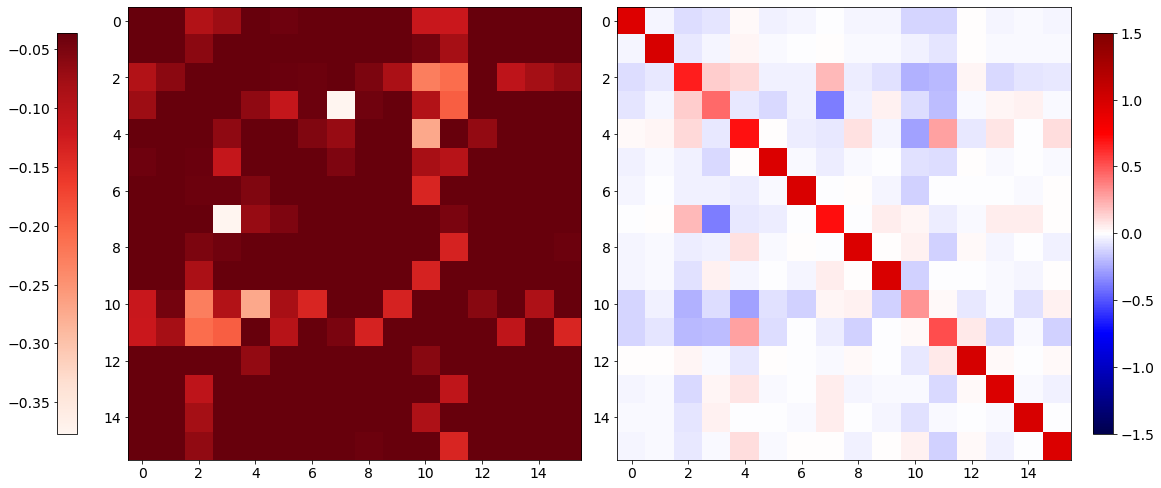

In [41]:
fig, axs = ground_truth_pair_plot(V, V, 
                                 overwrite_diags=False,
                                 vmin1=0,
                                 vmin2=-1.5, vmax2=1.5,
                                 cmap1=sequential, cmap2=divergent)